In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing
from typing import Type

import numpy as np
import torch

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
import devinterp.utils as utils

import re
import yaml
from dataclasses import dataclass


from dgp import get_dataloader
from model import GPT

import torch.nn.functional as F
from utils import move_to_device

import pickle
import os

In [3]:
config_file = "config/conf.yaml"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hf_repo_name = "px47qrx5"
dump_dir = f'results/scratch/{hf_repo_name}/llc'
model_dir = f'results/scratch/{hf_repo_name}'


os.makedirs(dump_dir, exist_ok=True)

In [4]:
def load_model_for_iteration(it, dirname, epoch = 0, device = device):
    fname = f'ckpt_epoch_{epoch}_iter_{it}.pt'
    return torch.load(f'{dirname}/{fname}', map_location=device)

In [5]:
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

conf_yaml = yaml.load(open(config_file), Loader=loader)

# convert yaml into a dataclass recursively
@dataclass
class Conf:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, dict):
                setattr(self, k, Conf(**v))
            else:
                setattr(self, k, v)
    
    def __repr__(self):
        yaml_str = yaml.dump(self.__dict__)
        return yaml_str
    
    def __str__(self) -> str:
        return self.__repr__()

config = Conf(**conf_yaml)

config.device = device

In [6]:
dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=config.data.num_iters * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
)

In [7]:
pad_token_id = dataloader.dataset.pad_token_id
def evaluate_fn(model, data):
    sequences, symb_sequences, seq_lengths, seq_logprobs, _  = data
    B = sequences.size(0)
    inputs, labels = move_to_device([sequences[:,:-1], sequences[:,1:]], config.device)
    labels = labels.clone()
    labels[labels == pad_token_id] = -100  # Mask padding
    logits = model(inputs)  # (B, L-1, V)
    loss = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        labels.reshape(-1),
        ignore_index=-100,
        reduction='none'
        ) # (B*L-1)
    loss = loss.reshape(B, -1).mean() 
    return loss, {}

In [8]:
def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 100.0,
    num_chains: int = 5,
    num_draws: int = 300,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = torch.device("cpu"),
    online: bool = True,
    verbose: bool = False,
):
    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [9]:
# analyzer = EpsilonBetaAnalyzer()
# analyzer.configure_sweep(
#     llc_estimator=estimate_llc_given_model,
#     llc_estimator_kwargs=dict(
#         model=model, loader=dataloader, evaluate=evaluate_fn, device=config.device
#     ),
#     min_epsilon=1e-6,
#     max_epsilon=1e-2,
#     epsilon_samples=8,
#     min_beta=None,
#     max_beta=None,
#     beta_samples=8,
#     dataloader=dataloader,
# )  # Automatically find a beta range from the optimal beta
# analyzer.sweep()

In [10]:
# analyzer.sweep_df.head()

In [11]:
def calculate_llc_default(iteration, dataloader):
    if torch.cuda.is_available() and device == 'cuda':
        torch.cuda.empty_cache()
    model_info = load_model_for_iteration(iteration, model_dir, epoch = 0)
    model = GPT(config.model, dataloader.dataset.PCSG.vocab_size)
    model.load_state_dict(model_info['net'])
    if torch.cuda.is_available() and device == 'cuda':
        torch.cuda.empty_cache()
    return estimate_learning_coeff_with_summary(
        model,
        loader=dataloader,
        evaluate=evaluate_fn,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-3, localization=200.0, nbeta= 30),
        num_chains=5,
        num_draws=100,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=config.device,
        online=True,
        verbose=True,
    )

In [12]:
# from tqdm import tqdm
# import multiprocessing as mp

# processes = []
# max_processes = 2
# llc_outputs = []
# iters = list(range(0, 41, 10))
# for iter in tqdm(iters):
#     while len(processes) >= max_processes:
#         # wait for a process to finish
#         for p in processes:
#             if not p.is_alive():
#                 p.join()
#                 processes.remove(p)
#                 break
    
#     assert len(processes) < max_processes
#     p = mp.Process(target=lambda: llc_outputs.append(calculate_llc_default(iter, dataloader)))
#     p.start()
#     processes.append(p)

# for p in processes:
#     p.join()


# for iter, llc in zip(iters, llc_outputs):
#     with open(f'{dump_dir}/llc_output_it_{iter}.pkl', 'wb') as f:
#         pickle.dump(llc, f)

In [13]:
from tqdm import tqdm
llc_outputs = []
iters = list(range(5_050, 10_001, 50))
for iter in tqdm(iters):
    print(f'Calculating LLC for iteration {iter}')
    llc_output = calculate_llc_default(iter, dataloader)
    llc_outputs.append(llc_output)
    with open(f'{dump_dir}/llc_output_it_{iter}.pkl', 'wb') as f:
        pickle.dump(llc_output, f)

 81%|████████  | 119/147 [1:51:11<25:09, 53.91s/it]

Calculating LLC for iteration 3650


 82%|████████▏ | 120/147 [1:52:05<24:15, 53.90s/it]

Calculating LLC for iteration 3700


 82%|████████▏ | 121/147 [1:53:00<23:33, 54.36s/it]

Calculating LLC for iteration 3750


 83%|████████▎ | 122/147 [1:53:54<22:33, 54.15s/it]

Calculating LLC for iteration 3800


 84%|████████▎ | 123/147 [1:54:48<21:37, 54.07s/it]

Calculating LLC for iteration 3850


 84%|████████▍ | 124/147 [1:55:42<20:44, 54.13s/it]

Calculating LLC for iteration 3900


 85%|████████▌ | 125/147 [1:56:36<19:49, 54.07s/it]

Calculating LLC for iteration 3950


 86%|████████▌ | 126/147 [1:57:30<18:51, 53.90s/it]

Calculating LLC for iteration 4000


 86%|████████▋ | 127/147 [1:58:23<17:58, 53.90s/it]

Calculating LLC for iteration 4050


 87%|████████▋ | 128/147 [1:59:17<17:02, 53.81s/it]

Calculating LLC for iteration 4100


 88%|████████▊ | 129/147 [2:00:12<16:16, 54.25s/it]

Calculating LLC for iteration 4150


 88%|████████▊ | 130/147 [2:01:07<15:25, 54.42s/it]

Calculating LLC for iteration 4200


 89%|████████▉ | 131/147 [2:02:01<14:28, 54.26s/it]

Calculating LLC for iteration 4250


 90%|████████▉ | 132/147 [2:02:55<13:34, 54.27s/it]

Calculating LLC for iteration 4300


 90%|█████████ | 133/147 [2:03:50<12:39, 54.28s/it]

Calculating LLC for iteration 4350


 91%|█████████ | 134/147 [2:04:44<11:47, 54.42s/it]

Calculating LLC for iteration 4400


 92%|█████████▏| 135/147 [2:05:40<10:59, 54.94s/it]

Calculating LLC for iteration 4450


 93%|█████████▎| 136/147 [2:06:36<10:06, 55.16s/it]

Calculating LLC for iteration 4500


 93%|█████████▎| 137/147 [2:07:32<09:14, 55.45s/it]

Calculating LLC for iteration 4550


 94%|█████████▍| 138/147 [2:08:26<08:15, 55.04s/it]

Calculating LLC for iteration 4600


 95%|█████████▍| 139/147 [2:09:21<07:18, 54.87s/it]

Calculating LLC for iteration 4650


 95%|█████████▌| 140/147 [2:10:15<06:23, 54.79s/it]

Calculating LLC for iteration 4700


 96%|█████████▌| 141/147 [2:11:10<05:27, 54.62s/it]

Calculating LLC for iteration 4750


 97%|█████████▋| 142/147 [2:12:06<04:35, 55.04s/it]

Calculating LLC for iteration 4800


 97%|█████████▋| 143/147 [2:13:00<03:38, 54.70s/it]

Calculating LLC for iteration 4850


 98%|█████████▊| 144/147 [2:13:54<02:43, 54.58s/it]

Calculating LLC for iteration 4900


 99%|█████████▊| 145/147 [2:14:49<01:49, 54.85s/it]

Calculating LLC for iteration 4950


 99%|█████████▉| 146/147 [2:15:45<00:55, 55.04s/it]

Calculating LLC for iteration 5000


100%|██████████| 147/147 [2:16:42<00:00, 55.80s/it]


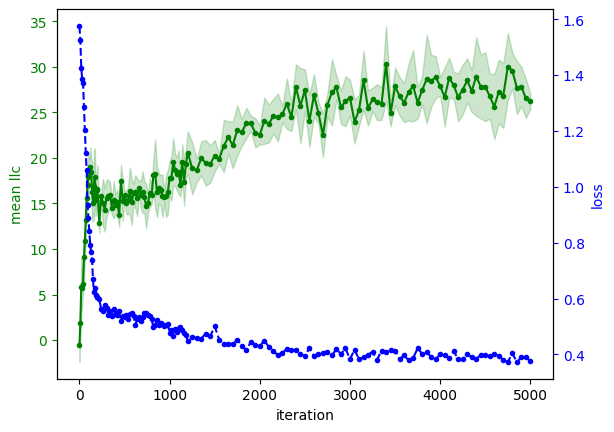

In [14]:
import matplotlib.pyplot as plt

llcs = llc_outputs
x = iters
y = [llc["llc/means"][-1] for llc in llcs]
y_err = [llc["llc/stds"][-1] for llc in llcs]
y_loss = [llc["init_loss"] for llc in llcs]
# plt.plot(x, y)

# plot x and y_loss with a scale on the right side
fig, ax1 = plt.subplots()
ax1.plot(x, y, 'g.-')
#fill between
ax1.fill_between(x, [y[i] - y_err[i] for i in range(len(y))], [y[i] + y_err[i] for i in range(len(y))], color='g', alpha=0.2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('mean llc', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x, y_loss, 'b.--')
ax2.set_ylabel('loss', color='b')
ax2.tick_params('y', colors='b')

plt.xscale('log')

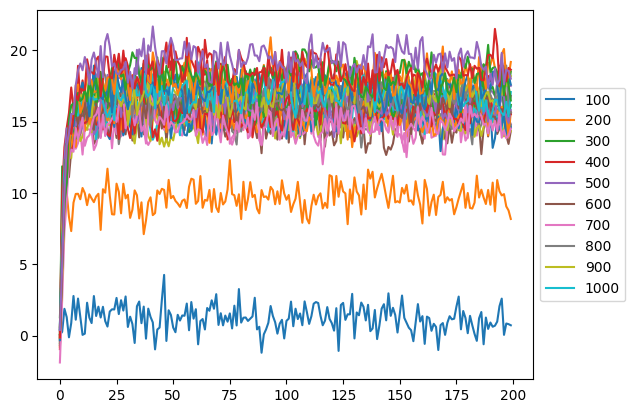

In [16]:
llc_traces = np.array([llc["llc/trace"] for llc in llcs])
meaned_traces = llc_traces.mean(axis=1)

for trace in meaned_traces:
    plt.plot(trace)
    plt.legend(list(range(100, 1001, 100)), loc='center left', bbox_to_anchor=(1, 0.5))

1.2542343 +/- 2.0049765


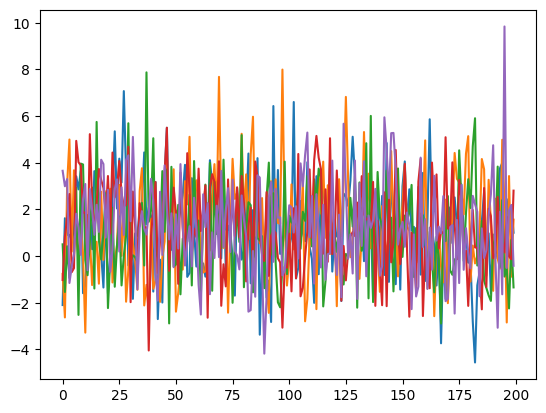

In [17]:
for trace in llc_traces[0]:
    plt.plot(trace)

print(llc_traces[0][-1].mean(), "+/-", llc_traces[0][-1].std())